In [359]:
import thinkdsp
import numpy as np
import thinkplot
import scipy.signal
import bitarray

%matplotlib inline

def reverse_notch_filter(segment2, qfactor=.99, freq=3400):
    x = segment2.ys
    y = [ 0 for i in xrange(len(segment2.ys))]
    q = .75
    p = .99
    wo = (freq * np.pi * 2) / segment2.framerate

    y[0] = x[0] + 2 * q - 2 * p

    y[1] = x[1] + 2 * p * np.cos(wo) * y[0] - 2 * q * np.cos(wo) * x[0]

    for i in range(2, len(segment2.ys)):
        y[i] = x[i] + 2* p * np.cos(wo) * y[i-1] - p * p * y[i - 2] - 2 * q * np.cos(wo) * x[i-1] + q*q*x[i - 2]
        #print(y[i])
    return thinkdsp.Wave(y, segment2.framerate)



# def reverse_notch_filter(segment, q=.9, freq=3400):
#     w = (freq * np.pi * 2) / segment.framerate
#     A = [1, -2.0*q*np.cos(w), 1]
#     B = [1, -2.0*q*np.cos(w), 1]
#     filt = scipy.signal.lfilter(B,A,segment.ys)
#     return filt
    

def detect_one_or_zero(segment, qfactor=.99, lowfreq=2300, highfreq=3400, sL=.5):
    if len(segment.ys) < 3:
        print("too short")
        return
    #segment = segment2.segment(sL/3, sL/4)
    lowwave = reverse_notch_filter(segment, qfactor, lowfreq)

    highwave = reverse_notch_filter(segment, qfactor, highfreq)
    
    lowAverage = np.average(np.absolute(lowwave.ys))
    highAverage = np.average(np.absolute(highwave.ys))
    if lowAverage > highAverage and lowAverage > 100: #tweak constant
        return False
    elif highAverage > lowAverage and highAverage > 100: #tweak me
        return True
def find_start_and_end(xf, threshold = 2000): 
    import numpy as np    
    start_idx = -1
 
    for k in range(0, len(xf)):
        if(np.abs(xf[k])) > threshold:
            start_idx = k
            break

    if(start_idx  < 0):
        print("Unable to detect start of transmission")
        return -1
    
    end_idx = -1
    
    for k in range(0, len(xf)):
        if(np.abs(xf[len(xf)-k-1])) > threshold:
            end_idx = len(xf)-k-1
            break

    if(end_idx < 0):
        print("Unable to detect end of transmission")
        return -1

    return start_idx, end_idx

def find_first_third_freq(wave, keyFreq = 5000):
    filteredWave = reverse_notch_filter(wave, freq=keyFreq)
    val = 0
    for i in filteredWave.ys:
        if i > 1000:
            val = i
            break
            
    itemindex = np.where(filteredWave.ys==val)
    print(itemindex)
    
    return thinkdsp.Wave(filteredWave.ys[itemindex[0]:], filteredWave.framerate)

def process_wav(wave, symbolLength=.5):
    subwave = find_first_third_freq(wave)
    #supersubwave = wave.segment(0, 5)
    #highWave = reverse_notch_filter(supersubwave, .99, 3400)
    #lowWave = reverse_notch_filter(supersubwave, .99, 2300)
    #keyWave = reverse_notch_filter(wave, .99, 5000)
    #lowWave.plot()
    b = bitarray.bitarray()
    for i in range(1, int(round(subwave.duration / symbolLength))):
        b.append(detect_one_or_zero(subwave.segment(i * symbolLength, symbolLength), sL=symbolLength))
    return b

In [360]:
#wav = reverse_notch_filter(test, qfactor=.99, freq=3400)
#wav.plot()

In [361]:
test = thinkdsp.read_wave("longrandomseed1000.wav")
b = process_wav(test, symbolLength=.05)

np.random.seed(1000)
bytes = np.random.bytes(8)
c = bitarray.bitarray()
c.frombytes(bytes)
print(b)
print(c)
if b == c:
    print("yay")

(array([1]),)
bitarray('1011001110100101010100011010011101010111000100101001111010011010')
bitarray('1011001110100101010100011010011101010111000100101001110100110100')


/Users/lego6245/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:87: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


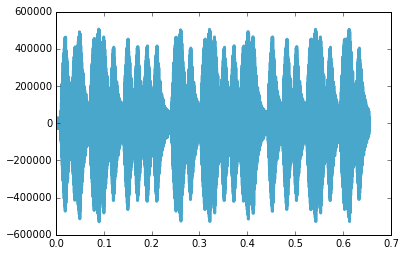

In [362]:
subwav = reverse_notch_filter(test)
subwav.plot()

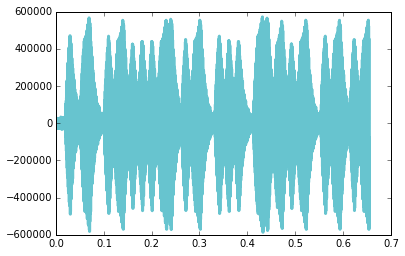

In [363]:
subwav = reverse_notch_filter(test, freq=2300)
subwav.plot()